In [1]:
import pandas as pd
import os
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import sklearn.gaussian_process.kernels as k
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
plt.rcParams["figure.figsize"] = (20,10)


In [2]:
#df = pd.read_excel (r'Mappings.xlsx')
p9690 =pd.read_csv (r'./Output/missing_value_imputed/p9690_missing.csv')#,parse_dates=['Timestamp'], index_col=['Timestamp'])
p9630 =pd.read_csv (r'./Output/missing_value_imputed/p9630_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p9888 =pd.read_csv (r'./Output/missing_value_imputed/p9888_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10049=pd.read_csv (r'./Output/missing_value_imputed/p10049_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])
p10412=pd.read_csv (r'./Output/missing_value_imputed/p10412_missing.csv')#, parse_dates=['Timestamp'], index_col=['Timestamp'])

In [3]:
p10049['Timestamp'] = pd.to_datetime(p10049['Timestamp'])
p10049['DOB'] = pd.to_datetime(p10049['DOB'])
p10049.set_index('Timestamp', inplace=True)

In [4]:
p10049.tail(24)

,UserID,Systolic,Diastolic,Heart Rate,DOB,Weight,Height,Gender
Timestamp,,,,,,,,
2019-03-17 12:00:00,10049.0,119.0,83.0,86.0,1963-04-07,44.5,158.0,F
2019-03-17 13:00:00,10049.0,120.0,90.0,103.0,1963-04-07,44.5,158.0,F
2019-03-17 14:00:00,10049.0,120.0,83.0,86.0,1963-04-07,44.5,158.0,F
2019-03-17 15:00:00,10049.0,NaN,NaN,NaN,1963-04-07,44.5,158.0,F
2019-03-17 16:00:00,10049.0,NaN,NaN,NaN,1963-04-07,44.5,158.0,F
2019-03-17 17:00:00,10049.0,NaN,NaN,NaN,1963-04-07,44.5,158.0,F
2019-03-17 18:00:00,10049.0,122.0,85.0,91.0,1963-04-07,44.5,158.0,F
2019-03-17 19:00:00,10049.0,122.0,84.0,88.0,1963-04-07,44.5,158.0,F
2019-03-17 20:00:00,10049.0,125.0,82.0,84.0,1963-04-07,44.5,158.0,F


In [5]:
p10049_s= p10049['Systolic']
p10049_d= p10049['Diastolic']
p10049_hr= p10049['Heart Rate']
p10049_all= p10049[['Systolic','Diastolic','Heart Rate']]
p10049_s_train,p10049_s_test= np.split(p10049_s, [int(.7 *len(p9690))])
p10049_d_train,p10049_d_test= np.split(p10049_d, [int(.7 *len(p9690))])
p10049_hr_train,p10049_hr_test= np.split(p10049_hr, [int(.7 *len(p9690))])
p10049_all_train,p10049_all_test= np.split(p10049_all, [int(.7 *len(p9690))])



interpolation

In [6]:
df_poly_imputed = p10049_all.interpolate(method='polynomial', order=5)
df_time_imputed = p10049_all.interpolate(method='time')
df_spline_imputed = p10049_all.interpolate(method='spline', order=5)
df_barycentric_imputed = p10049_all.interpolate(method='barycentric', order=2)


KNN Inputation

In [7]:
# Imputing with KNNImputer

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#Define a subset of the dataset
df_knn = p10049_all.copy()
#p9690.filter(['Systolic','Diastolic','Heart Rate'], axis=1).copy()


# Define scaler to set values between 0 and 1

scaler = MinMaxScaler(feature_range=(0, 1))
df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)

# Define KNN imputer and fill missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


Multivariate Imputation by Chained Equations (MICE)

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

df_mice = p10049_all.copy()

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')
df_mice_imputed = pd.DataFrame(mice_imputer.fit_transform(df_mice), columns=df_mice.columns)

In [9]:
import statsmodels as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [10]:
df = df_time_imputed

In [11]:
df_train = df[:-24]
df_test  = df[-24:]

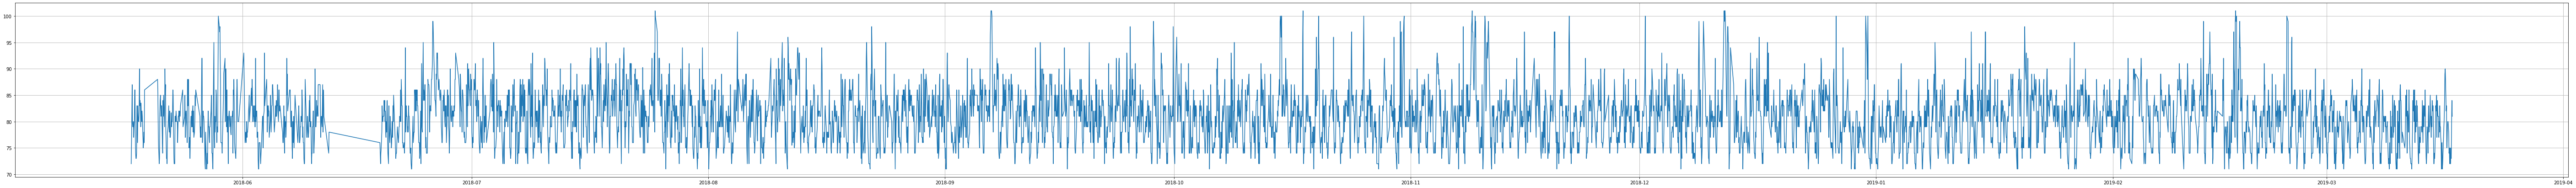

In [18]:
plt.figure(figsize=(100,7))
plt.grid()
plt.plot(df_train.Diastolic)
plt.title('')
plt.show()

In [19]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(df_train.Diastolic, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -28.848898
P-Value                    0.000000
# Lags Used                4.000000
# Observations Used     7293.000000
Critical Value (1%)       -3.431247
Critical Value (5%)       -2.861936
Critical Value (10%)      -2.566981
dtype: float64


Text(0.5, 1.0, 'Diastolic differencing')

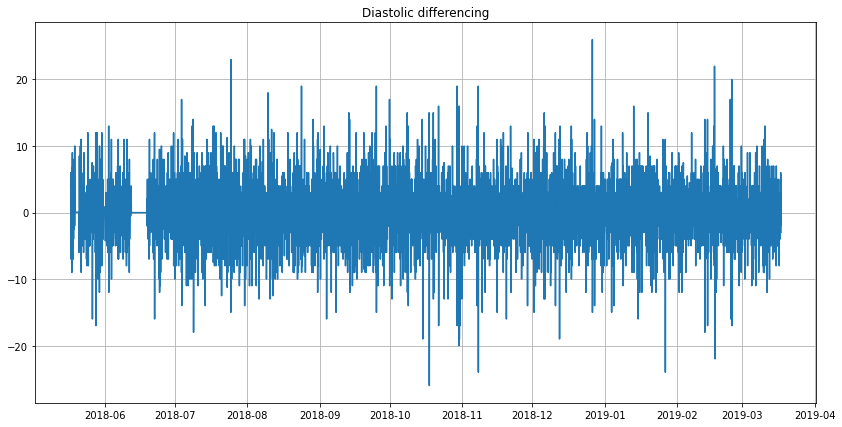

In [20]:
# trend differencing
df_diff_train = df_train.Diastolic.diff(1)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(df_diff_train)
plt.title('Diastolic differencing')

Text(0.5, 1.0, 'Systolic seasonal differencing')

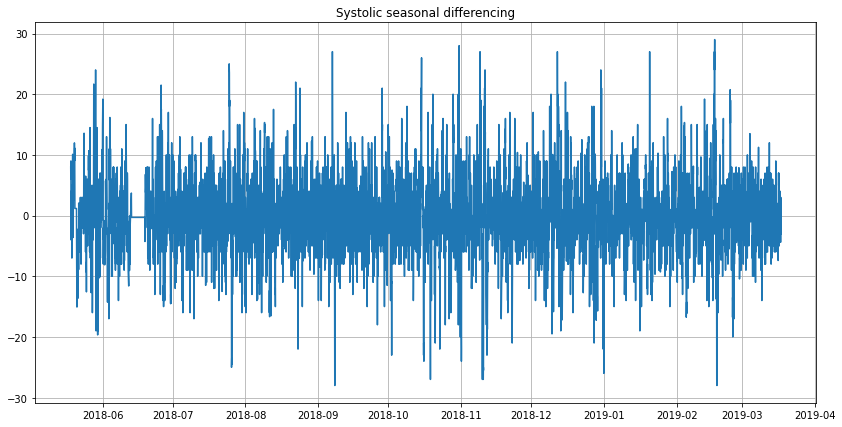

In [21]:
# seasonal differencing
df_season_diff_train = df_train.Diastolic.diff(24)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(df_season_diff_train)
plt.title('Systolic seasonal differencing')

In [22]:
print_adf_result(adfuller(df_season_diff_train.dropna()))


Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -23.910993
P-Value                    0.000000
# Lags Used               24.000000
# Observations Used     7249.000000
Critical Value (1%)       -3.431252
Critical Value (5%)       -2.861939
Critical Value (10%)      -2.566982
dtype: float64


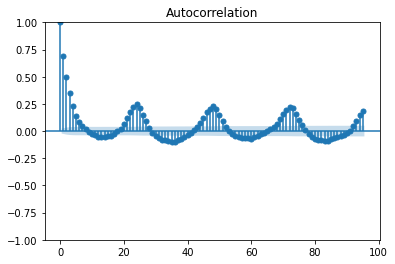

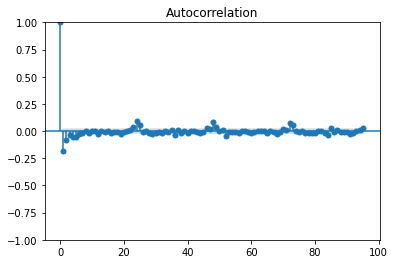

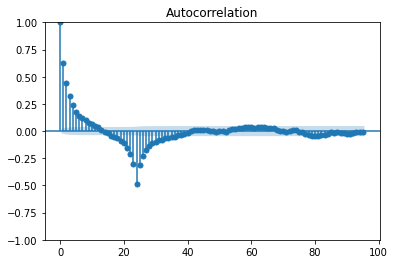

In [23]:
# plot ACF plot
# plot ACF plot

plot_acf(df_train.Diastolic.dropna(), lags=range(0,96));
plot_acf(df_diff_train.dropna(), lags=range(0,96));
plot_acf(df_season_diff_train.dropna(), lags=range(0,96));

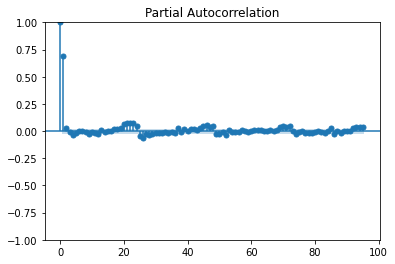

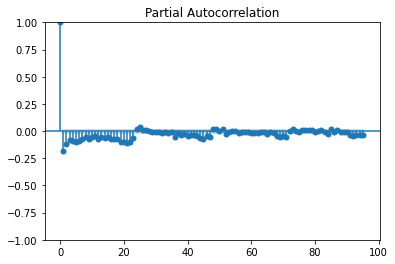

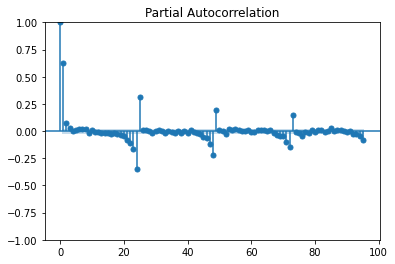

In [24]:
plot_pacf(df_train.Diastolic.dropna(), lags=range(0,96));
plot_pacf(df_diff_train.dropna(), lags=range(0,96));
plot_pacf(df_season_diff_train.dropna(), lags=range(0,96));


In [25]:
from statsmodels.tsa.arima.model import ARIMA

arima_111 = ARIMA(df_train.Diastolic, order=(1,0,0)).fit()
arima_111.summary()

C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\Hypertension_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Diastolic   No. Observations:                 7298
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -19954.935
Date:                Fri, 19 Aug 2022   AIC                          39915.870
Time:                        14:02:05   BIC                          39936.556
Sample:                    05-17-2018   HQIC                         39922.983
                         - 03-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         80.9400      0.155    523.674      0.000      80.637      81.243
ar.L1          0.6934      0.007     93.703      0.000       0.679       0.708
sigma2        13.8824      0.172     80.559      0.000      13.545      14.220
===================================================================================
Ljung-Box (L1) (Q):                   3.42   Jarque-Bera (JB):              2051.05
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.43
Prob(H) (two-sided):                  0.38   Kurtosis:                         5.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
residuals = pd.Series(arima_111.resid)


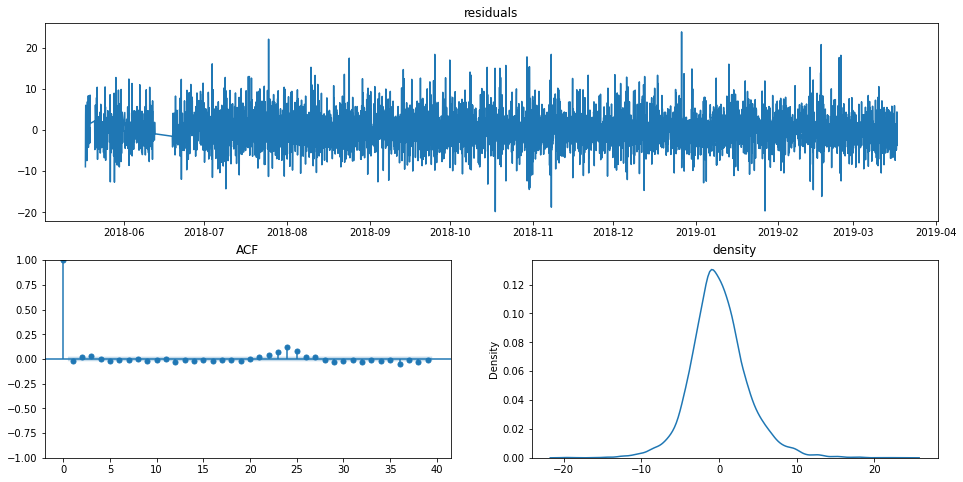

In [22]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)


In [29]:
arima_forecast = arima_111.forecast(24)


In [74]:
arima_forecast

2019-03-17 12:00:00    80.981604
2019-03-17 13:00:00    80.968848
2019-03-17 14:00:00    80.960003
2019-03-17 15:00:00    80.953869
2019-03-17 16:00:00    80.949616
2019-03-17 17:00:00    80.946666
2019-03-17 18:00:00    80.944621
2019-03-17 19:00:00    80.943203
2019-03-17 20:00:00    80.942220
2019-03-17 21:00:00    80.941538
2019-03-17 22:00:00    80.941065
2019-03-17 23:00:00    80.940737
2019-03-18 00:00:00    80.940510
2019-03-18 01:00:00    80.940352
2019-03-18 02:00:00    80.940243
2019-03-18 03:00:00    80.940167
2019-03-18 04:00:00    80.940114
2019-03-18 05:00:00    80.940078
2019-03-18 06:00:00    80.940053
2019-03-18 07:00:00    80.940035
2019-03-18 08:00:00    80.940023
2019-03-18 09:00:00    80.940015
2019-03-18 10:00:00    80.940009
2019-03-18 11:00:00    80.940005
Freq: H, Name: predicted_mean, dtype: float64

arima_100.forecast(1)
array([6.13733224]),
 array([9.93220506]),
 array([[-13.32943197,  25.60409644]])) should have this but only one value

plt.figure(figsize=(20,7))

arima_forecast = pd.Series(arima_forecast, index=df_test.index)
#lower_series = pd.Series(conf[:, 0], index=df_test.index)
#upper_series = pd.Series(conf[:, 1], index=df_test.index)
plt.plot(df_test.Systolic, label='train')
plt.plot(arima_forecast, label='forecast')

#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [30]:

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

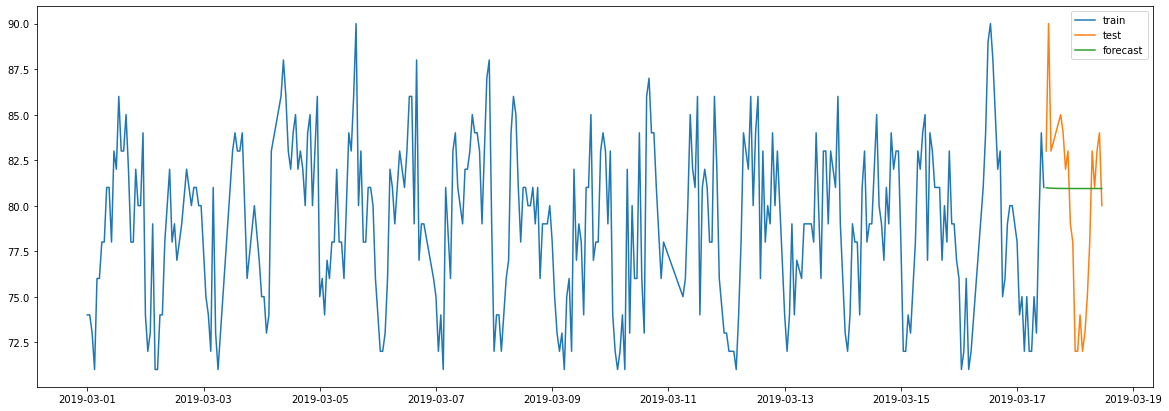

In [31]:
plt.figure(figsize=(20,7))

train_test_forecast_plot(df_train.Diastolic.loc['2019-03-01 00:00:00':'2019-03-17 12:00:00'],df_test.Diastolic,arima_forecast)

In [32]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
   
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(arima_forecast, df_test['Diastolic'])

{'mape': 0.051362287403503765,
 'me': 0.6956497615998808,
 'mae': 4.004627248133046,
 'mpe': 0.012469907198025681,
 'rmse': 4.896600566866402,
 'corr': 0.4882521672643977,
 'minmax': 0.048481647632351854}

In [80]:
import statsmodels.api as sm
mod =  sm.tsa.statespace.SARIMAX(df_train.Systolic, order=(1,0,0),seasonal_order=(0, 2, 0, 24))
results = mod.fit()
print (results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Systolic   No. Observations:                 7298
Model:             SARIMAX(2, 0, 0)x(0, 2, 0, 24)   Log Likelihood              -27387.240
Date:                            Fri, 19 Aug 2022   AIC                          54780.480
Time:                                    14:26:11   BIC                          54801.146
Sample:                                05-17-2018   HQIC                         54787.588
                                     - 03-17-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4546      0.009     53.471      0.000       0.438       0.471
ar.L2          0.0990      0.010   

In [68]:
res = mod.filter(results.params)

In [69]:
predict = res.get_prediction(96)
predict_ci = predict.conf_int()

In [81]:
forecast =  res.get_forecast(24)

In [71]:
predict_dy = res.get_prediction(96)
predict_dy_ci = predict_dy.conf_int()

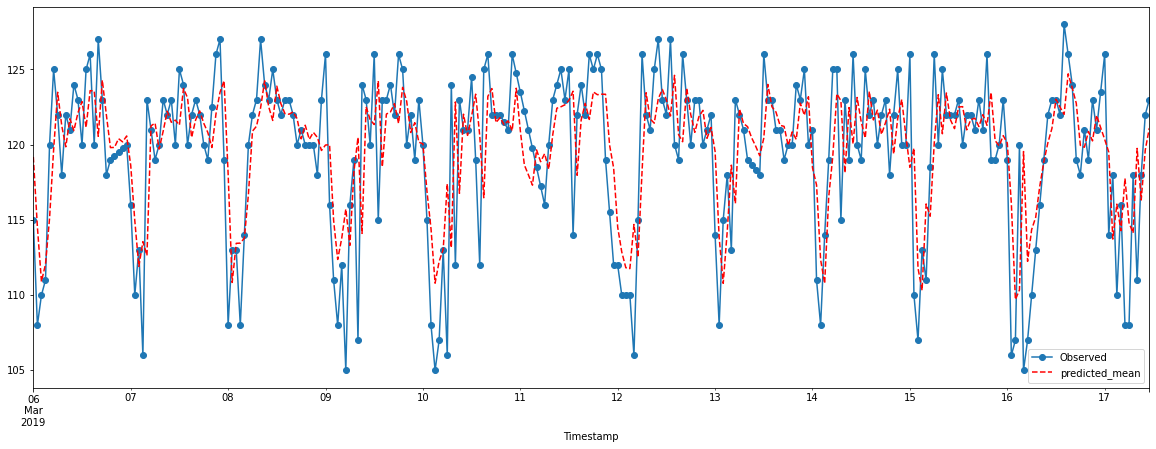

In [58]:
# Graph
fig, ax = plt.subplots(figsize=(20,7))
npre = 24

# Plot data points
df_train.Systolic.loc['2019-03-06 00:00:00':].plot(ax=ax, style='o-', label='Observed')

# Plot predictions
predict.predicted_mean.loc['2019-03-06 00:00:00':].plot(ax=ax, style='r--', )
#ci = predict_ci.loc['2019-03-06 00:00:00':]
#ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
forecast.pred_mean.loc['2019-03-06 00:00:00':].plot(ax=ax, style='r--', )


legend = ax.legend(loc='best')

In [32]:
param_p = [1]
param_d = [0,1] # ARIMA only support two times of differencing
param_q = [0,1,2]
param_P = [0,1,2]
param_D = [0,1,2]
param_Q = [0,1,2]



In [35]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            for P in param_P:
                for D in param_D:
                    for Q in param_Q:
                        try:
                            arima = sm.tsa.statespace.SARIMAX(df_train.Diastolic, order=(p,d,q),seasonal_order=(P, D, Q, 24)).fit()
                            if best_error is None or arima.aic < best_error:
                                best_error = arima.aic
                                best_params = (p,d,q)
                                best_model = arima
                            print('SARIMA({},{},{})({},{},{}), AIC={},BIC={}'.format(p,d,q,P,D,Q, arima.aic,arima.bic))
                        except:
                            pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(df_test.Systolic, arima_forecast)
print('Test MSE: ', mse)
import math
math.sqrt(22.902591447916176)

Grid Search

In [ ]:
param_p = [0,1,2,3,4,5]
param_d = [0,1,2] # ARIMA only support two times of differencing
param_q = [0,1,2,3,4,5]

In [ ]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(df_train.Diastolic, order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))